## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys, shutil
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random


In [3]:
import importlib
pardir = os.path.abspath("../") 
if pardir not in sys.path:
    sys.path.append(pardir)
from utils.DLutils import *
from utils.vizutils import *
from create_toybrains import ToyBrainsData
from experiments.fit_DL_model import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


First, generate the toybrain datasets 

Refer to the notebook `toybrains/experiments/gen_lbl1cov1_configs.ipynb` for an example on how to generate the dataset.
Alternatively, if you have a config such as `configs.lbl1cov1` you can simply run,
```bash
! nohup python3 create_toybrains.py -c configs.lbl1cov1 -n 10000 --suffix n &> nohup1.out &
```

In [4]:
DATASETS = sorted([os.path.abspath(path) for path in glob("../dataset/toybrains_n10000_lblmidr_covsite_t*")])
print("Fitting DL model on the following toybrains datasets:")
DATASETS

Fitting DL model on the following toybrains datasets:


['/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t0',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t1',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t2',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t3',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t4']

In [ ]:
# get their corresponding config files
CONFIGS = {}
for data_dir in DATASETS:
    config_file_suffix = os.path.basename(data_dir).split("_")
    config_file = glob(f"../configs/*{config_file_suffix[-2]}*/*{config_file_suffix[-1]}*.py")[0]
    CONFIGS.update({data_dir: config_file})

### Generative attr. dist.

In [5]:
# for data_dir in DATASETS:
#     data_name = data_dir.split('/')[-1]
#     df = pd.read_csv(f'{data_dir}/{data_name}.csv')
#     cov_cols = df.filter(regex='^(cov_|lbl_)').columns
#     attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
#     plot_col_dists(df, 
#                    attr_cols=attr_cols, cov_cols=cov_cols, 
#                    title=f"{data_name}: Dist. of generative data attributes vs the labels")
#     plt.show()

### Baseline attr. accuracies

In [6]:
results = []
for data_dir in DATASETS:
    toy = ToyBrainsData(data_dir)
    # load the already generated dataset
    toy.load_generated_dataset(data_dir)
    result = toy.fit_baseline_models(CV=10) 
    results.append(result)

AssertionError: 

## Estimate ground-truth contributions
of confounding signal and the true signal

There exists a relationship, 

$ S_{total} = f(S_{conf} , S_{true}, \epsilon )$ , where $\epsilon$ is the noise added by the other image attributes.

$ S_{superset} = f(S_{conf}, S_{true})$
I need to find the function $f$ 

### (1) estimate it by fitting separate linear models

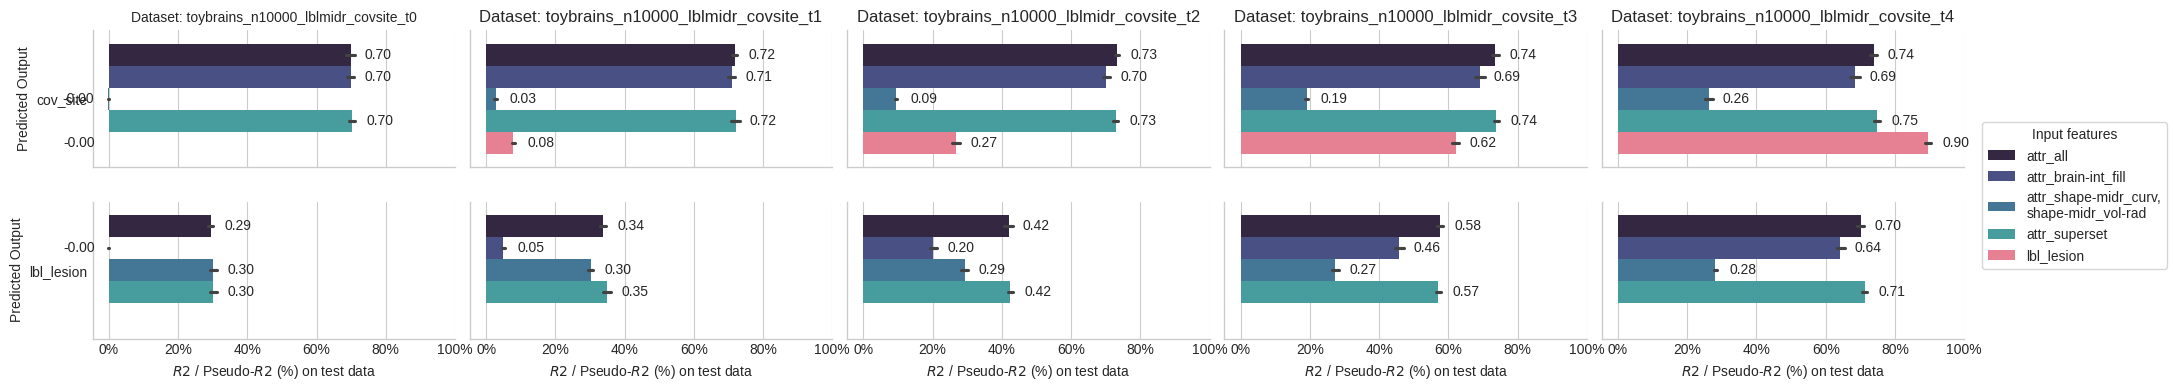

In [ ]:
viz_baseline_results(results)

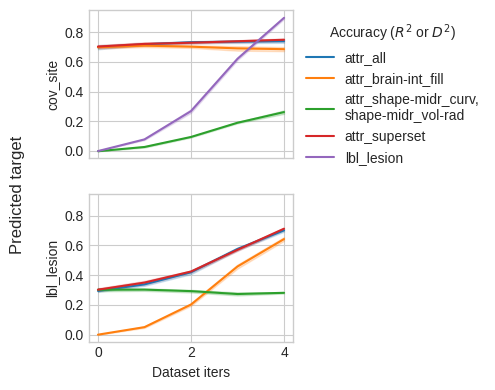

In [ ]:
viz_baseline_results_summary(results)

#### collect the results in a dataframe

In [ ]:
df_baseline = pd.concat(results)

In [ ]:
grp_by_cols = ['dataset', 'inp']
signal_col = 'test_metric'
df_baseline_temp = df_baseline.loc[df_baseline.out.apply(lambda x: 'lbl_' in x).values, grp_by_cols+[signal_col]]
df_baseline_temp = df_baseline_temp.groupby(grp_by_cols).mean().reset_index()
df_baseline_temp.inp = df_baseline_temp.inp.map({'attr_all':r'S_{total}', 
                                                 'attr_superset':r'S_{superset}', 
                                                 'attr_shape-midr_curv, shape-midr_vol-rad':r'S_{true}',
                                                 'attr_brain-int_fill':r'S_{conf}'})

In [ ]:
df_final = {}
cols = []
for dataset, dfi in df_baseline_temp.groupby("dataset"):
    dfi = dfi[['inp','test_metric']].T
    dfi.columns = dfi.loc['inp'].values
    dfi = dfi.drop(index='inp')
    if not len(cols): 
        cols = dfi.columns
    vals = [dfi[c].values[0] for c in cols]
    df_final.update({dataset: vals})
    
df_final = pd.DataFrame.from_dict(df_final, orient='index', columns=cols)
df_final.index.name = 'Dataset'
df_final.index = df_final.index.str.split('/').str[-1]
df_final.style.bar(vmin=0, vmax=1)

,S_{total},S_{conf},S_{true},S_{superset}
Dataset,,,,
toybrains_n10000_lblmidr_covsite_t0,0.293799,-0.000726,0.301661,0.302150
toybrains_n10000_lblmidr_covsite_t1,0.337924,0.050030,0.302628,0.349860
toybrains_n10000_lblmidr_covsite_t2,0.419251,0.202016,0.292453,0.424371
toybrains_n10000_lblmidr_covsite_t3,0.576490,0.458372,0.272927,0.570560
toybrains_n10000_lblmidr_covsite_t4,0.701184,0.642631,0.281049,0.712636


In [ ]:
# divide the df_final cell values by the $S_{total}$ value in that column
print(r"relative performance of the subset models with respect to the total superset ($D^2$ performance)")
df_final_1 = df_final[['S_{total}', 'S_{true}', 'S_{conf}']]
df_final_1 = df_final_1.div(df_final_1['S_{total}'], axis=0)
df_final_1.style.bar(vmin=0, vmax=1)

relative performance of the subset models with respect to the total superset ($D^2$ performance)


,S_{total},S_{true},S_{conf}
Dataset,,,
toybrains_n10000_lblmidr_covsite_t0,1.000000,1.026762,-0.002470
toybrains_n10000_lblmidr_covsite_t1,1.000000,0.895550,0.148050
toybrains_n10000_lblmidr_covsite_t2,1.000000,0.697560,0.481851
toybrains_n10000_lblmidr_covsite_t3,1.000000,0.473428,0.795107
toybrains_n10000_lblmidr_covsite_t4,1.000000,0.400821,0.916495


### (2) estimate it using SHAP

**Derivation: SHAP to contrib score**

There is a problem with using the SHAP values directly as a proxy for grouth truth contributions of the attributes to the model prediction. We use a logistic regression model and it is NOT additive in the probability space. 

If we instead use the log-odds output of the model we see a perfect linear relationship between the models inputs and the model's outputs.

Therefore, we need to transform the SHAP values into such an additive space (lets call it `relative contrib` values) of the log-odds.

**Deriving `relative contrib` values from SHAP values:**

For a data point $X_i$, we expect the following relationship between SHAP values of different attributes for logistic regression: 

$ \text{sigmoid} ( \sum_{j}(\text{shap}(X_i, a_j)) + \text{baseshap}(X_i)) = \text{proba}(X_i) $  $\quad \quad \quad $.... ([source](https://github.com/shap/shap/issues/352#issuecomment-445925342))

$\quad \quad \quad \quad \quad \quad \quad \quad \quad$ where, $ \text{sigmoid}(x) = 1/(1+\epsilon^{-x})$


$ ( \sum_{j}(\text{shap}(X_i, a_j)) + \text{baseshap}(X_i)) = sigmoid^{-1} (proba(X_i)) $

$  \sum_{j}(\text{shap}(X_i, a_j)) = \text{logit} (proba(X_i)) - \text{baseshap}(X_i) $ $\quad \quad \quad $.... since $ sigmoid^{-1} = \text{logit}(p) = \ln \left( \frac{p}{1 - p} \right)$

For a given sample $X_i$, the right hand side of the above equation is a constant, say $C$. \
The relative contribution of each feature $a_j$ to this total $C$ is given by, 

$ \frac{\text{shap}(X_i, a_j)}{C} $  $\quad \quad \quad $....  such that,   $\sum\limits_{a_j} \frac{\text{shap}(X_i, a_j)}{C}  = 1$

Averaging this across all the dataset samples $N$, we can get the ground-truth contribution of a feature $a_j$ as a percentage, \
$ \text{contrib}(a_j) =\frac{1}{N} \times  | \sum\limits_{X_i} \frac{\text{shap}(X_i, a_j)}{C} | \times 100 $ 



In [8]:
df_shap_results = viz_contribs_shap(results, top_n=5)

ValueError: No objects to concatenate

### Compare (1) and (2)

In [ ]:
from create_toybrains import ToyBrainsData
# importlib.reload(sys.modules['create_toybrains'])
importlib.reload(sys.modules[ToyBrainsData.__module__])

results = []
for data_dir, config_file in DATASETS:
    toy = ToyBrainsData(config_file)
    # load the already generated dataset
    toy.load_generated_dataset(data_dir)
    result = toy.fit_baseline_models(["attr_all"], CV=10) 
    results.append(result)
    # break 

running a total of 20 different settings of [input] x [output] x [CV] and saving result in /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t0








100%|██████████| 20/20 [00:01<00:00, 12.11it/s]


TOTAL RUNTIME: 0:00:04
running a total of 20 different settings of [input] x [output] x [CV] and saving result in /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t1








100%|██████████| 20/20 [00:01<00:00, 12.38it/s]


TOTAL RUNTIME: 0:00:04
running a total of 20 different settings of [input] x [output] x [CV] and saving result in /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t2








100%|██████████| 20/20 [00:01<00:00, 12.44it/s]


TOTAL RUNTIME: 0:00:04
running a total of 20 different settings of [input] x [output] x [CV] and saving result in /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t3








100%|██████████| 20/20 [00:01<00:00, 12.15it/s]


TOTAL RUNTIME: 0:00:04
running a total of 20 different settings of [input] x [output] x [CV] and saving result in /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t4








100%|██████████| 20/20 [00:01<00:00, 12.79it/s]


TOTAL RUNTIME: 0:00:04


## load libraries

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# standard python packages
import os, sys, shutil
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random


In [ ]:
import importlib
pardir = os.path.abspath("../") 
if pardir not in sys.path:
    sys.path.append(pardir)
from utils.DLutils import *
from utils.vizutils import *
from create_toybrains import ToyBrainsData
from experiments.fit_DL_model import *

First, generate the toybrain datasets 

Refer to the notebook `toybrains/experiments/gen_lbl1cov1_configs.ipynb` for an example on how to generate the dataset.
Alternatively, if you have a config such as `configs.lbl1cov1` you can simply run,
```bash
! nohup python3 create_toybrains.py -c configs.lbl1cov1 -n 10000 --suffix n &> nohup1.out &
```

In [ ]:
DATASETS = sorted([os.path.abspath(path) for path in glob("../dataset/toybrains_n10000_lblmidr_covsite_t*")])
print("Fitting DL model on the following toybrains datasets:")
DATASETS

Fitting DL model on the following toybrains datasets:


['/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t0',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t1',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t2',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t3',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t4']

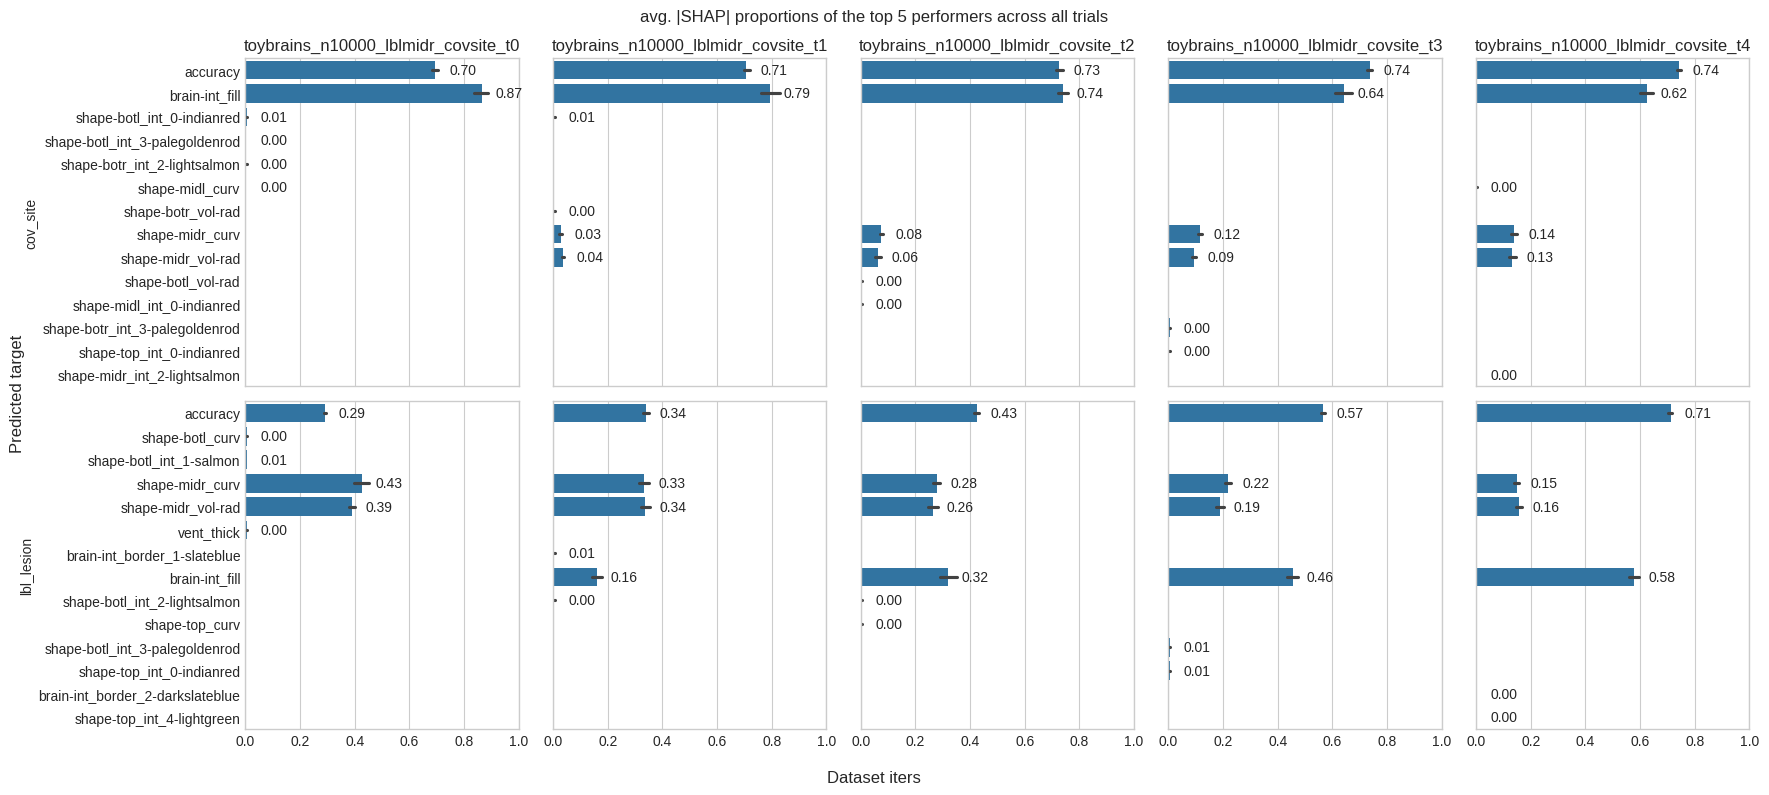

In [106]:
# df_shap_results_only = df_shap_results.drop(columns=['model', 'dataset', 'out', 'inp', 'trial', 'accuracy'])
# # divide every cell by the max value in that column
# df_shap_results_only = df_shap_results_only.div(df_shap_results_only.max(axis=0), axis=1)
# df_shap_results_only


In [114]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from glob import glob
import math

In [115]:
shap_values_list = []
for fname in glob("/ritter/roshan/workspace/shap_values_f*.pickle"):
     with open(fname, 'rb') as f:
          shap_values = pickle.load(f)
     with open(fname.replace('values', 'values_predprobas'), 'rb') as f:
          predicted_probas = pickle.load(f)
     shap_values_list.append([shap_values, predicted_probas])

assert len(shap_values_list)>0, "No shap values found!"

In [150]:
s, probas = shap_values_list[1]
s.values.shape, s.base_values.shape, s.data.shape, probas.shape, s.feature_names


((2000, 49),
 (2000,),
 (2000, 49),
 (2000, 2),
 ['brain-int_border_0-mediumslateblue',
  'brain-int_border_1-slateblue',
  'brain-int_border_2-darkslateblue',
  'brain-int_border_3-darkblue',
  'shape-top_int_0-indianred',
  'shape-top_int_1-salmon',
  'shape-top_int_2-lightsalmon',
  'shape-top_int_3-palegoldenrod',
  'shape-top_int_4-lightgreen',
  'shape-top_int_5-darkgreen',
  'shape-midr_int_0-indianred',
  'shape-midr_int_1-salmon',
  'shape-midr_int_2-lightsalmon',
  'shape-midr_int_3-palegoldenrod',
  'shape-midr_int_4-lightgreen',
  'shape-midr_int_5-darkgreen',
  'shape-midl_int_0-indianred',
  'shape-midl_int_1-salmon',
  'shape-midl_int_2-lightsalmon',
  'shape-midl_int_3-palegoldenrod',
  'shape-midl_int_4-lightgreen',
  'shape-midl_int_5-darkgreen',
  'shape-botr_int_0-indianred',
  'shape-botr_int_1-salmon',
  'shape-botr_int_2-lightsalmon',
  'shape-botr_int_3-palegoldenrod',
  'shape-botr_int_4-lightgreen',
  'shape-botr_int_5-darkgreen',
  'shape-botl_int_0-indianred

In [68]:
# Visualize the SHAP values for each instance as force plots
shap.initjs()
shap.plots.force(s, shap_values=s[0,:], show=False)

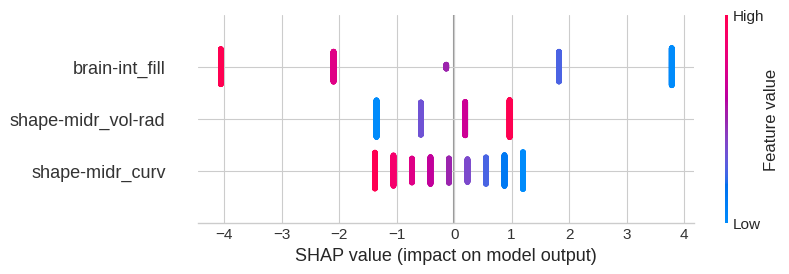

In [69]:
# Visualize the summary of SHAP values across instances
shap.initjs()
shap.plots.beeswarm(s, max_display=10, show=True)

In [151]:
from scipy.special import logit
total_const = logit(probas[:,1])-s.base_values[0]

In [152]:
SHAP_contribs = np.apply_along_axis(arr=s.values,      axis=0, func1d = lambda x: x/total_const)
# standardize the SHAP values to be in the range [0,1] from [-1,1]
# SHAP_contribs = np.apply_along_axis(arr=SHAP_contribs, axis=0, func1d = lambda x: (x-x.min())/(x.max()-x.min()))
SHAP_contribs

array([[ 0.01124912, -0.00734686,  0.00431937, ...,  0.00243762,
        -0.00818184,  0.03464435],
       [-0.00755288, -0.0126844 , -0.00290011, ...,  0.00046162,
        -0.0046796 ,  0.02388955],
       [-0.00569617,  0.0037202 , -0.00218718, ..., -0.00044309,
         0.00797912, -0.00568953],
       ...,
       [-0.0083464 , -0.01401706, -0.0032048 , ..., -0.00064925,
         0.0060706 ,  0.02639944],
       [ 0.00360433, -0.00235401, -0.00374184, ...,  0.00078104,
         0.00708787,  0.00360013],
       [ 0.00588907, -0.00384618,  0.00226125, ..., -0.00035993,
         0.00761476, -0.00637239]])

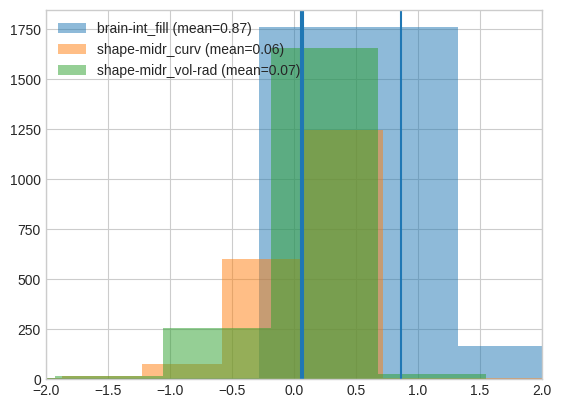

In [157]:
# plot the histogram of the each feature in the SHAP_contribs matrix
for i in range((SHAP_contribs.shape[-1])):
    if s.feature_names[i] in ['shape-midr_curv', 'shape-midr_vol-rad', 'brain-int_fill']:
        plt.hist(SHAP_contribs[:, i], bins=100, label=f"{s.feature_names[i]} (mean={SHAP_contribs[:, i].mean():.2f})", alpha=0.5)
        # also show the mean as a vertical line
        plt.axvline(SHAP_contribs[:, i].mean(), label=None)
# plt.hist(shap_probas_all, density=True, label='All', alpha=0.5)
plt.xlim(-2,2)
plt.legend()
plt.show()

In [70]:
# from scipy.special import expit
# def get_expit(shap_values, base_values):
#     return expit(shap_values + base_values)

In [71]:
# shap_sum = s.values.sum(axis=1)
# shap_sum_probas =  get_expit(shap_sum, s.base_values)
# shap_i_probas = np.array([get_expit(s.values[:,i], s.base_values) for i in range(s.values.shape[-1])]).sum(axis=0)
# shap_sum_probas, shap_i_probas

In [72]:
def expit_mine(shap_vals_i, base=s.base_values[0]):
    return 1/(1+math.exp(-(shap_vals_i.sum(axis=-1) + base)))

In [73]:
shap_sum = s.values.sum(axis=1)
shap_probas_all =  np.apply_along_axis(arr=s.values, axis=-1, func1d=expit_mine)
print("Does the above equation hold true for all datapoints (i) ?\n",
    np.all(shap_probas_all-probas[:,1]<1e-8)) # 1e-8 for numerical stability
shap_probas_all

Does the above equation hold true for all datapoints (i) ?
 True


array([0.11913301, 0.99770205, 0.01542152, ..., 0.00241663, 0.95335003,
       0.99640018])

In [74]:
shap_probas_i = []
for i in range(s.values.shape[-1]):
    s_vals = s.values.copy()
    for j in range(s.values.shape[-1]):
        if i!=j:
            s_vals[:,j] = 0

    shap_probas_i.append(np.apply_along_axis(arr=s_vals, axis=-1, func1d=expit_mine_prod))


shap_probas_i = np.array(shap_probas_i).T
shap_probas_i.shape, shap_probas_i


((2000, 3),
 array([[0.43274594, 0.14299168, 0.63190411],
        [0.78139246, 0.98361516, 0.76575673],
        [0.62282857, 0.02292114, 0.39513661],
        ...,
        [0.26059382, 0.02292114, 0.32129515],
        [0.62282857, 0.89407247, 0.70317212],
        [0.62282857, 0.98361516, 0.81855075]]))

In [ ]:
shap_probas_i.sum(axis=-1).shape

(2000,)

In [ ]:
np.apply_along_axis(arr=shap_probas_i, axis=-1, func1d=expit_mine)

array([1., 1., 1., ..., 1., 1., 1.])

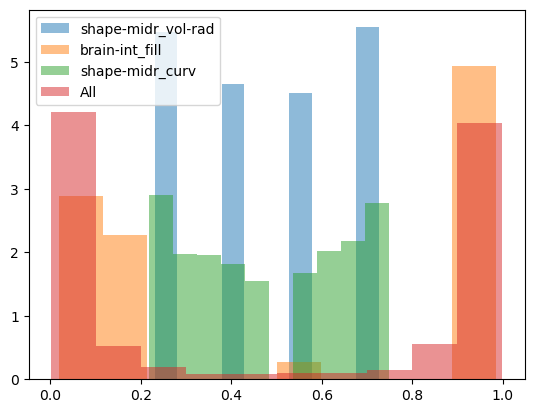

In [ ]:
for i in range((shap_probas_i.shape[-1])):
    plt.hist(shap_probas_i[:, i], density=True, 
             label=f"{s.feature_names[i]}", alpha=0.5)
plt.hist(shap_probas_all, density=True, label='All', alpha=0.5)
plt.legend()
plt.show()

Accuracy:  0.9813529477590947
Coefficients:  [[-4.86883520e+06  8.41335507e+06 -3.68414718e+07  8.66967815e+06
  -1.11100226e+10  1.55003843e+10 -1.28947469e+10 -7.36424708e+09
   5.51060388e+09  1.68330878e+10 -2.03111681e+09  8.49104600e+08
   1.23807327e+09 -5.79705839e+09 -1.57388703e+09 -1.50756268e+09
   1.22925812e+08 -2.06751084e+08 -4.23648756e+08 -3.47950185e+08
   1.53816964e+08 -2.15250347e+08 -4.41739550e+09 -5.21918610e+09
   2.47579721e+09 -2.48550582e+09  2.81845765e+09  1.80704882e+10
  -5.74218804e+09 -2.35109012e+10  1.55221926e+10 -1.04724010e+10
   9.29205386e+09  6.95745030e+09  1.35586739e-01  6.14608288e-01
   3.44827652e-01  9.28115845e-01  3.67658615e-01  1.20928288e-02
   2.00481653e-01  2.73658752e-01  2.66481400e-01  2.48828053e-01
   3.31045389e-01  4.99397993e-01  8.55805635e-01  1.69578791e-01
   2.03751951e-01]]


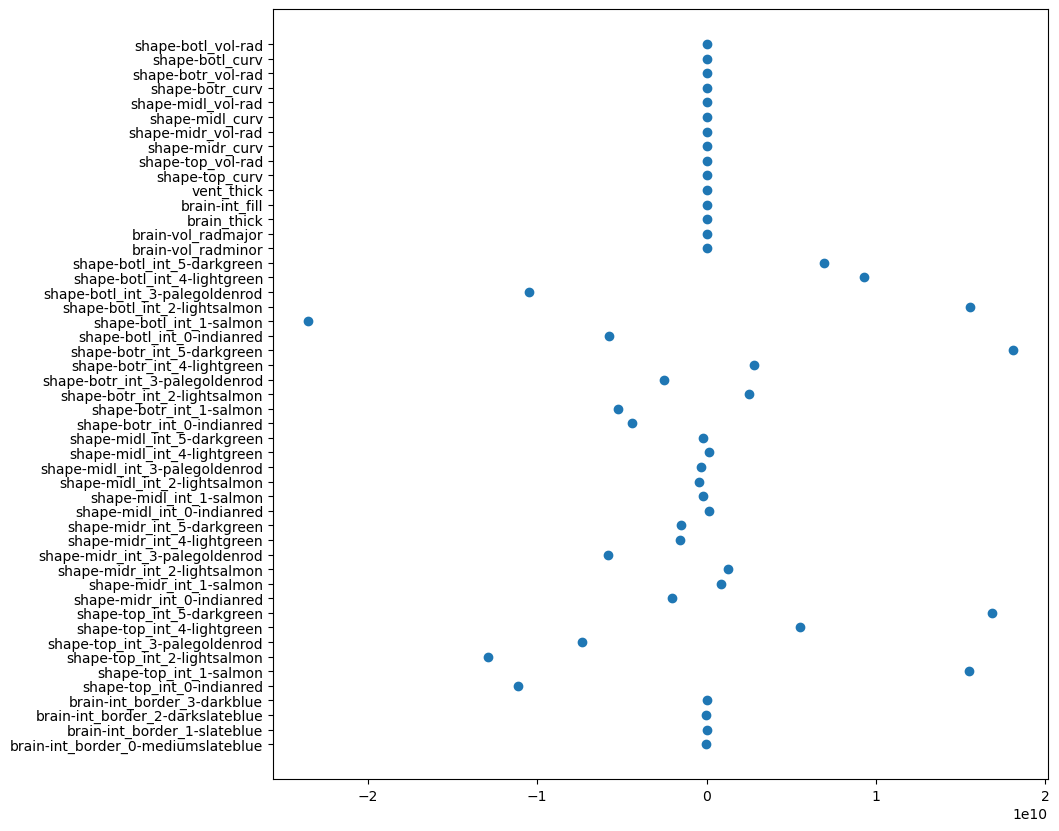

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False) 
shap_probas_i = np.array(shap_probas_i)
model.fit(shap_probas_i, shap_probas_all.reshape(-1,1))
print("Accuracy: ", model.score(shap_probas_i, shap_probas_all.reshape(-1,1)))
print("Coefficients: ", model.coef_)

f, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x =model.coef_.ravel(), y = s.feature_names, marker='o')
plt.show()


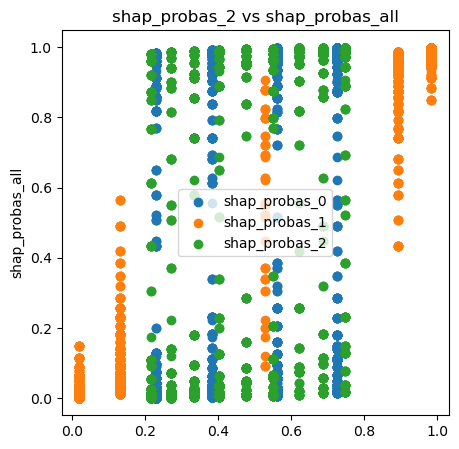

In [ ]:
# plot each of the features in shap_probas_i vs the shap_probas_all as subplots
fig, ax = plt.subplots(1,1, figsize=(5, 5))
for i in range(len(shap_probas_i)):
    ax.scatter(shap_probas_i[i], shap_probas_all, label=f"shap_probas_{i}")
    ax.set_ylabel(f"shap_probas_all")
    ax.set_title(f"shap_probas_{i} vs shap_probas_all")
plt.legend()
plt.show()

In [ ]:
1/(1+np.apply_along_axis(axis=-1, arr=s.values, 
                         func1d=lambda x: math.exp(x, s.base_values[0])).prod(axis=1))

array([0.78405769, 0.90566303, 0.85507883, ..., 0.97133022, 0.9835999 ,
       0.83195186])

In [ ]:
sum_of_expits = np.apply_along_axis(axis=-1, arr=s.values, func1d=lambda x: get_expit(x, s.base_values[0])).sum(axis=1)
[get_expit(s.values[:,i], s.base_values[0]) for i in range(s.values.shape[1])]

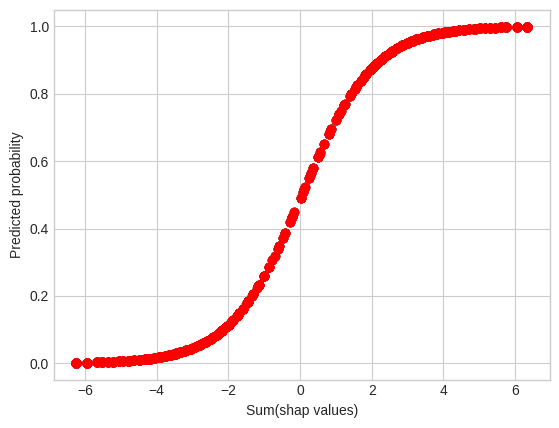

In [ ]:
# plot a distribution of the sum of shap values vs the predicted probability
plt.scatter(shap_sum, probas[:,1], label="model probas")
# plt.scatter(shap_sum, shap_probas, label="SHAP probas", color='r')
plt.xlabel("Sum(shap values)")
plt.ylabel("Predicted probability")
plt.show()